In [1]:
import torch.nn as nn
import pandas as pd
import numpy as np
from matplotlib import pyplot
import pandas as pd
import numpy as np
import torch
import yfinance as yf
from matplotlib import pyplot
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns 
import os
from torch import optim, nn, utils, Tensor
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
import lightning as L
file_path = 'data\BB_Rates_15min_from_10-2023.xlsx'
data = pd.read_excel(file_path)


In [2]:
start_index = 3
EURUSD = data.iloc[start_index:, :2]

# Rename the columns
EURUSD.columns = ['Dates', 'Close']
# Convertiere 'Dates' spalte zu Datetime format
EURUSD['Dates'] = pd.to_datetime(EURUSD['Dates'])
#EURUSD.head()


In [3]:
# Convertiere 'Dates' spalte zu Datetime format
EURUSD['Dates'] = pd.to_datetime(EURUSD['Dates'])
time_interval = pd.Timedelta(minutes=15)
# Calculate the difference between consecutive dates
EURUSD['TimeDiff'] = EURUSD['Dates'].diff()

# Identify the sections with consecutive 15-minute intervals
EURUSD['IsConsecutive'] = EURUSD['TimeDiff'] == time_interval
EURUSD['Block'] = (EURUSD['IsConsecutive'] != EURUSD['IsConsecutive'].shift()).cumsum()

In [4]:
# Filter out sections with fewer than 2 days of consecutive 15-minute observations
min_consecutive_minutes = 2 * 24 * 60  # 2 days in minutes
valid_blocks = EURUSD.groupby('Block').filter(lambda x: len(x) >= min_consecutive_minutes / 15).Block.unique()
EURUSD_filtered = EURUSD[EURUSD['Block'].isin(valid_blocks)]

# Add the observation timeframe column
EURUSD_filtered['TimeFrame'] = EURUSD_filtered.groupby('Block').cumcount() + 1

# Drop the 'TimeDiff' and 'IsConsecutive' columns as they are no longer needed
EURUSD_filtered = EURUSD_filtered.drop(columns=['TimeDiff', 'IsConsecutive'])

# Display the first few rows of the filtered dataset with the new 'Block' and 'TimeFrame' columns
print(EURUSD_filtered.head())

                Dates   Close  Block  TimeFrame
4 2023-10-03 23:15:00  1.0466      2          1
5 2023-10-03 23:30:00  1.0465      2          2
6 2023-10-03 23:45:00  1.0465      2          3
7 2023-10-04 00:00:00  1.0468      2          4
8 2023-10-04 00:15:00  1.0467      2          5


C:\Users\nilsw\AppData\Local\Temp\ipykernel_41828\2151116645.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  EURUSD_filtered['TimeFrame'] = EURUSD_filtered.groupby('Block').cumcount() + 1


In [5]:
block_mapping = {old_block: new_block for new_block, old_block in enumerate(EURUSD_filtered['Block'].unique(), 1)}

In [6]:
EURUSD_filtered = EURUSD_filtered.reset_index(drop=True)
EURUSD_filtered = EURUSD_filtered.drop(columns=['TimeFrame'])
EURUSD_filtered.head()

,Dates,Close,Block
0,2023-10-03 23:15:00,1.0466,2
1,2023-10-03 23:30:00,1.0465,2
2,2023-10-03 23:45:00,1.0465,2
3,2023-10-04 00:00:00,1.0468,2
4,2023-10-04 00:15:00,1.0467,2


In [7]:
from sklearn.preprocessing import MinMaxScaler

def create_dataset(lookback, forecast_horizon, data):
        X, Y = [], []
        scaler = MinMaxScaler(feature_range = (0, 1))
        for i in range(len(data) - lookback - forecast_horizon + 1):
            if data.iloc[i]['Block'] == data.iloc[i + lookback + forecast_horizon - 1]['Block']:
                X_values = data.iloc[i:i+lookback]['Close'].values
                Y_values = data.iloc[i+lookback:i+lookback+forecast_horizon]['Close'].values
                X_scaled = scaler.fit_transform(X_values.reshape(-1, 1))
                Y_scaled = scaler.transform(Y_values.reshape(-1, 1))
                X.append(X_scaled)
                Y.append(Y_scaled)
        return np.array(X), np.array(Y), scaler
X, Y, scaler = create_dataset(lookback=60, forecast_horizon=1, data=EURUSD_filtered)

In [8]:
x_train,y_train = np.array(X), np.array(Y)
x_train= np.reshape(x_train,( x_train.shape[0] ,x_train.shape[1] ,1))

In [9]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
model = Sequential()
model.add(LSTM(50, return_sequences = True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM( 50, return_sequences = False))
model.add(Dropout(0.2))
model.add(Dense(25))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mean_squared_error')


C:\Users\nilsw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [10]:
model.save_weights('keras_model.weights.h5')

In [11]:
model.save('my_model.keras')

In [12]:
model.fit(x_train, y_train, epochs = 10, batch_size = 32)

Epoch 1/10
366/366 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - loss: 0.0724
Epoch 2/10
366/366 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 0.0266
Epoch 3/10
366/366 ━━━━━━━━━━━━━━━━━━━━ 12s 32ms/step - loss: 0.0275
Epoch 4/10
366/366 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - loss: 0.0277
Epoch 5/10
366/366 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - loss: 0.0203
Epoch 6/10
366/366 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 0.0214
Epoch 7/10
366/366 ━━━━━━━━━━━━━━━━━━━━ 12s 32ms/step - loss: 0.0221
Epoch 8/10
366/366 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - loss: 0.0219
Epoch 9/10
366/366 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - loss: 0.0231
Epoch 10/10
366/366 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - loss: 0.0223


In [13]:

class LSTM_Modell(L.LightningModule):
    def __init__(self):
        super(LSTM_Modell, self).__init__()
        self.lstm = nn.LSTM(1, 50, 2, batch_first=True)
        self.dropout = nn.Dropout(0.2)  # Dropout layer hinzufügen
        self.fc1 = nn.Linear(50, 25)
        self.fc2 = nn.Linear(25, 1)
        self.loss = nn.MSELoss()

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.dropout(x[:, -1, :])  # Dropout auf den letzten LSTM-Ausgabewert anwenden
        x = torch.relu(self.fc1(x))  # ReLU-Aktivierungsfunktion nach der ersten Dense-Schicht anwenden
        x = self.fc2(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss(y_hat, y)
        self.log('train_loss', loss)
        return loss

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=0.001)

        



In [14]:
lstm_modell = LSTM_Modell()
dataset = utils.data.TensorDataset(Tensor(x_train), Tensor(y_train))
train_loader = utils.data.DataLoader(dataset, batch_size=32)

In [15]:
trainer = L.Trainer(limit_train_batches=32, max_epochs=10)
trainer.fit(model=lstm_modell, train_dataloaders=train_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | lstm    | LSTM    | 31.0 K | train
1 | dropout | Dropout | 0      | train
2 | fc1     | Linear  | 1.3 K  | train
3 | fc2     | Linear  | 26     | train
4 | loss    | MSELoss | 0      | train
--------------------------------------------
32.3 K    Trainable params
0         Non-trainable params
32.3 K    Total params
0.129     Total estimated model params size (MB)
C:\Users\nilsw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
C:\Users\nilsw\AppData\Local\Pack

Epoch 0:   3%|▎         | 1/32 [00:00<00:02, 12.91it/s, v_num=18]

C:\Users\nilsw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([32, 1, 1])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 9: 100%|██████████| 32/32 [00:01<00:00, 22.22it/s, v_num=18]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 32/32 [00:01<00:00, 22.13it/s, v_num=18]


In [16]:
new = yf.download(tickers ='EURUSD=X',start ='2024-06-01',end ='2024-06-29',interval= '15m' )
new = new.filter(['Close'])
new_dataset = new.values
new_data = scaler.transform(new_dataset)
test = []
for i in range(60,len(new_data)):
    test.append(new_data[i-60:i,0])
test = np.array(test)
test = np.reshape(test, (test.shape[0],test.shape[1],1))
new_predictions = model.predict(test)

test = torch.tensor(test).float()
lstm_modell.eval()
with torch.no_grad():
    new_predictions2 = lstm_modell(test)

new_predictions = scaler.inverse_transform(new_predictions)
new_predictions2 = new_predictions2.numpy()
new_predictions2 = scaler.inverse_transform(new_predictions2)

[*********************100%%**********************]  1 of 1 completed


58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


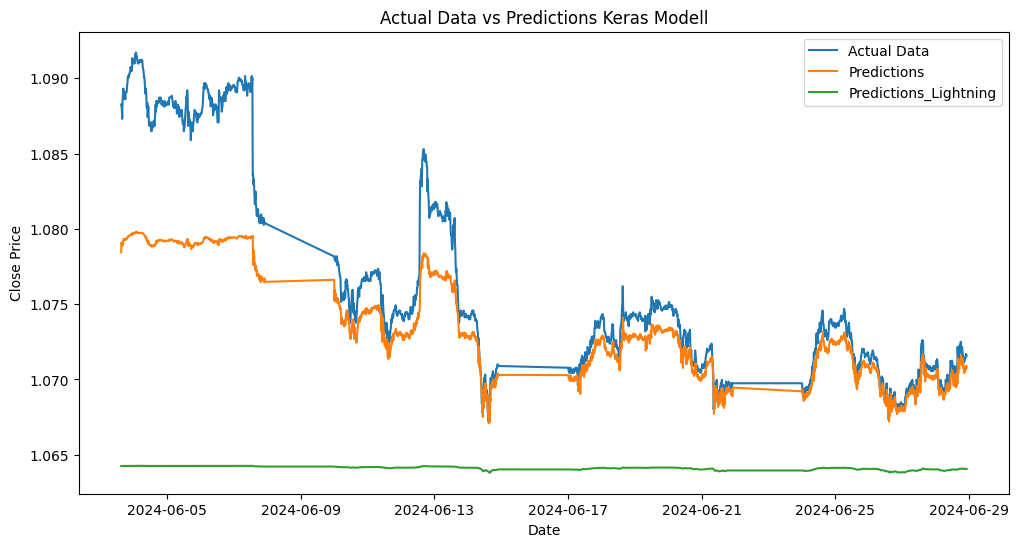

In [17]:
import matplotlib.pyplot as plt

# Plot the actual data
plt.figure(figsize=(12, 6))  # Set the figure size
plt.plot(new.index[60:], new[60:], label='Actual Data')

# Plot the predictions
plt.plot(new.index[60:], new_predictions, label='Predictions')
plt.plot(new.index[60:], new_predictions2, label='Predictions_Lightning')

# Set the labels and title
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Actual Data vs Predictions Keras Modell')

# Add a legend
plt.legend()

# Show the plot
plt.show()

In [49]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import tensorflow as tf
import keras
from keras import ops
from keras import layers


In [63]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.seed_generator = keras.random.SeedGenerator(1337)

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = ops.shape(z_mean)[0]
        dim = ops.shape(z_mean)[1]
        epsilon = keras.random.normal(shape=(batch, dim), seed=self.seed_generator)
        return z_mean + ops.exp(0.5 * z_log_var) * epsilon


In [78]:
latent_dim = 10
hidden = 50 

encoder_inputs = keras.Input(shape= (x_train.shape[1], 1))
x = layers.LSTM(hidden, return_sequences=True)(encoder_inputs)
x = layers.LSTM(hidden, return_sequences=False)(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_14      │ (None, 60, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_21 (LSTM)      │ (None, 60, 50)    │     10,400 │ input_layer_14[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_22 (LSTM)      │ (None, 50)        │     20,200 │ lstm_21[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 10)        │        510 │ lstm_22[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 10)        │        510 │ lstm_22[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling_4          │ (None, 10)        │          0 │ z_mean[0][0],     │
│ (Sampling)          │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 31,620 (123.52 KB)

 Trainable params: 31,620 (123.52 KB)

 Non-trainable params: 0 (0.00 B)

In [119]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = Dense(100)(latent_inputs)
x = layers.RepeatVector(x_train.shape[1])(x)
x = layers.LSTM(100, return_sequences=True)(x)
x = layers.LSTM(100, return_sequences=True)(x)
decoder_outputs = layers.TimeDistributed(Dense(1))(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_16 (InputLayer)     │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 100)            │         1,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_5 (RepeatVector)  │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_25 (LSTM)                  │ (None, 60, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_26 (LSTM)                  │ (None, 60, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 60, 1)          │           101 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 162,001 (632.82 KB)

 Trainable params: 162,001 (632.82 KB)

 Non-trainable params: 0 (0.00 B)

In [120]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)
        return reconstructed, z_mean, z_log_var
    
    
    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = ops.mean(
                ops.sum(
                    keras.losses.binary_crossentropy(data, reconstruction),
                    axis= 1,
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var))
            kl_loss = ops.mean(ops.sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {"loss": total_loss}

In [121]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())

In [122]:
vae.fit(x_train, epochs=50, batch_size=32)


Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 58ms/step - loss: 172.5663
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 53.8383
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 45.7912
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step - loss: 45.5859
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 45.6180
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - loss: 44.8028
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 45.0774
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - loss: 44.3083
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - loss: 44.1376
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 44.0797
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - loss: 43.8230
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 43.6663
Epoch 13/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - loss: 43.3683
Epoch 14/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 43.4161
Epoch 15/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step 

58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step


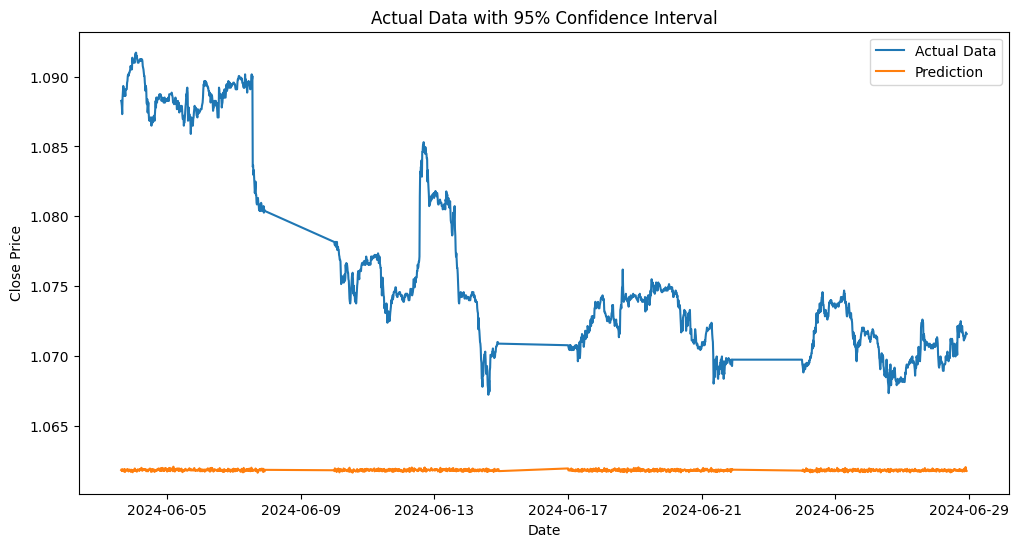

In [123]:
import numpy as np
import matplotlib.pyplot as plt

# Vorbereitung der Testdaten (Annahme: `new_dataset` ist vorbereitet und `scaler` ist definiert)
new_data = scaler.transform(new_dataset)
test = []
for i in range(60, len(new_data)):
    test.append(new_data[i-60:i, 0])
test = np.array(test)

test = np.reshape(test, (test.shape[0], test.shape[1], 1))

# Vorhersagen und Unsicherheiten berechnen
new_predictions, z_mean, z_logvar = vae.predict(test)
new_predictions = new_predictions.squeeze()

# Inverse Transformation der Vorhersagen
new_predictions = scaler.inverse_transform(new_predictions)

# Berechnung der Standardabweichung und des Konfidenzintervalls
std_dev = np.sqrt(np.exp(z_logvar))
upper_bound = z_mean + 1.96 * std_dev  # Using 1.96 standard deviations for 95% confidence interval
lower_bound = z_mean - 1.96 * std_dev

# Plot der Zeitreihe und des Konfidenzintervalls
plt.figure(figsize=(12, 6))
plt.plot(new.index[60:], new[60:], label='Actual Data')  # Annahme: `new` ist die Originalzeitreihe, auf die sich `test` bezieht
plt.plot(new.index[60:], new_predictions[:,0], label='Prediction')
# Sicherstellen, dass lower_bound und upper_bound die gleiche Länge haben wie die Zeitreihe, die geplottet wird
time_steps = np.arange(len(new.index[60:]))
#for dim in range(10):



plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Actual Data with 95% Confidence Interval')
plt.legend()
plt.show()
